Определить две бизнес-цели для набора данных по Вашему варианту задания. 

1.  Увеличить средний балл по математике среди студентов групп льготников (те, кто на льготном питании, чьи родители без высшего образования).
2. Снизить процент студентов, которые бросают учебу и прогуливают после первого семестра.

Определить цели технического проекта для каждой выделенной ранее бизнес
цели. 

1.1 Разработать систему прогнозирования и выявления студентов группы "риска" по низкой успеваемости в начале семестра.

2.1 Разработать систему раннего предупреждения о риске снижения успеваемости

Сбор и подготовка данных

In [ ]:
import pandas as pd
import numpy as np

# Загрузка датасета
data = pd.read_csv('data_3/StudentsPerformance.csv')

print(data.head())

print(data.isnull().sum())


   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75  
gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course    

Выполнить разбиение каждого набора данных на обучающую, контрольную и 
тестовую выборки для устранения проблемы просачивания данных. 

In [ ]:
from sklearn.model_selection import train_test_split

X = data.drop('math score', axis=1)
y = data['math score']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.666, random_state=42
)

print(f"Обучающая: {X_train.shape[0]} ({X_train.shape[0]/len(data)*100:.1f}%)")
print(f"Валидационная: {X_val.shape[0]} ({X_val.shape[0]/len(data)*100:.1f}%)")
print(f"Тестовая: {X_test.shape[0]} ({X_test.shape[0]/len(data)*100:.1f}%)")

Обучающая: 700 (70.0%)
Валидационная: 100 (10.0%)
Тестовая: 200 (20.0%)


=== ОЦЕНКА СБАЛАНСИРОВАННОСТИ ВЫБОРОК ===

ОБУЧАЮЩАЯ ВЫБОРКА:


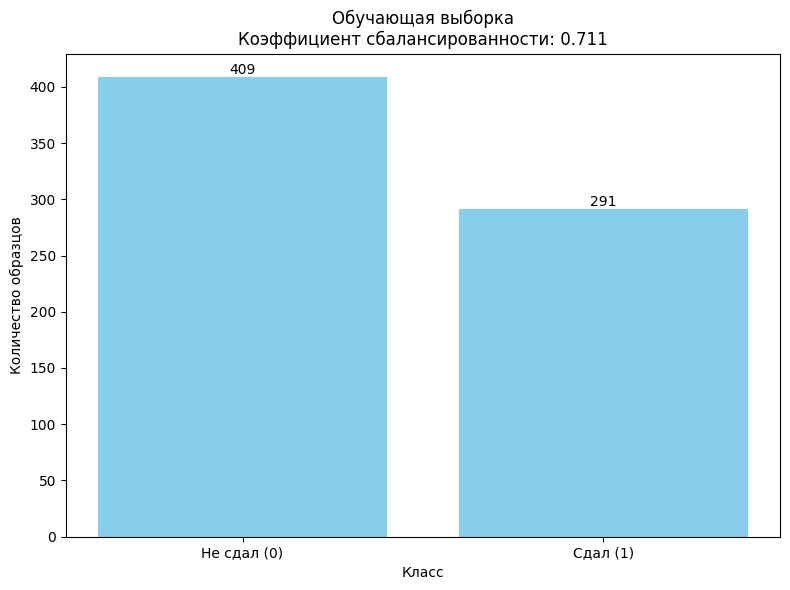

Распределение целевой переменной:
math_pass
0    409
1    291
Name: count, dtype: int64
Коэффициент сбалансированности: 0.711

ВАЛИДАЦИОННАЯ ВЫБОРКА:


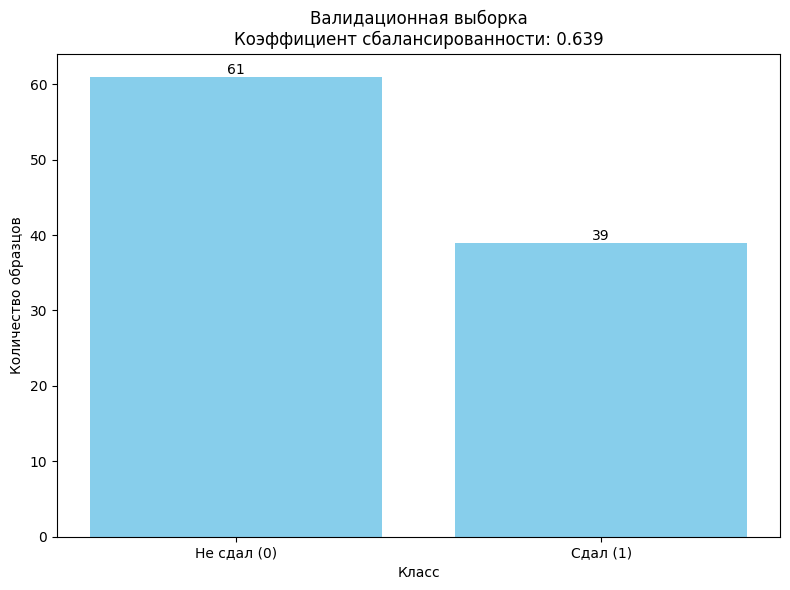

Распределение целевой переменной:
math_pass
0    61
1    39
Name: count, dtype: int64
Коэффициент сбалансированности: 0.639

ТЕСТОВАЯ ВЫБОРКА:


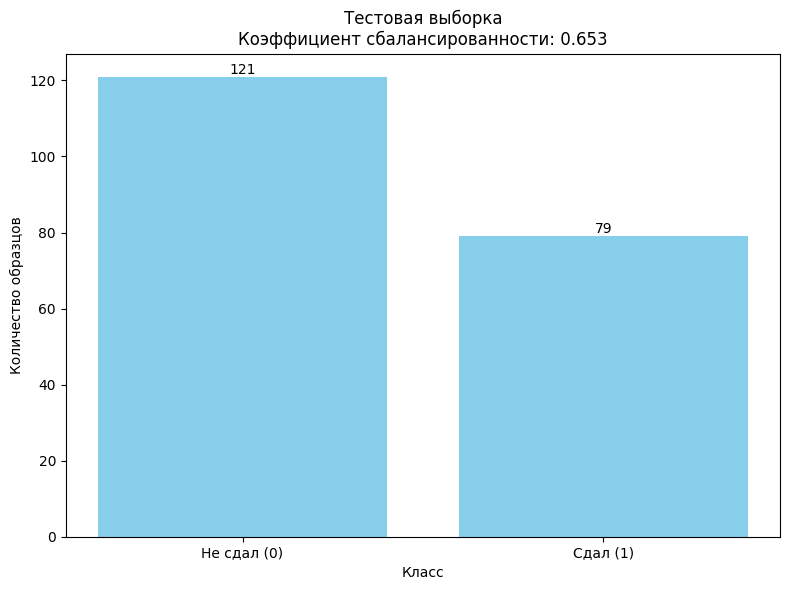

Распределение целевой переменной:
math_pass
0    121
1     79
Name: count, dtype: int64
Коэффициент сбалансированности: 0.653



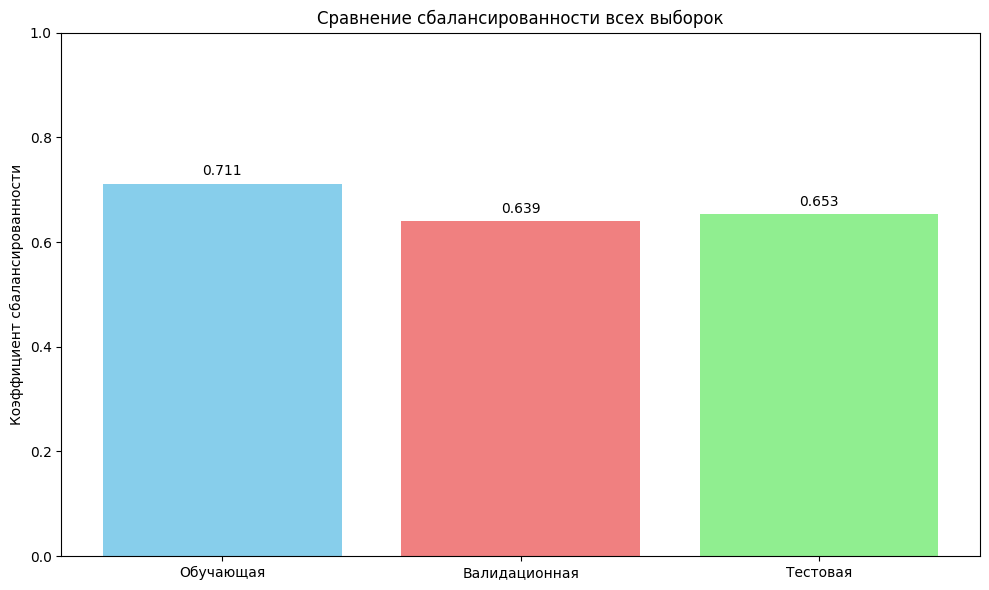


=== ПРОВЕРКА НЕОБХОДИМОСТИ АУГМЕНТАЦИИ ===
Обучающая выборка: 0.711 >= 0.5 - сбалансирована
Валидационная выборка: 0.639 >= 0.5 - сбалансирована
Тестовая выборка: 0.653 - НЕ АУГМЕНТИРУЕТСЯ


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')
sns.set_palette("husl")

def assess_balance_with_plot(dataset, target_column, dataset_name):
    value_counts = dataset[target_column].value_counts()
    balance_ratio = value_counts.min() / value_counts.max()
    
    # Столбчатая диаграмма
    plt.figure(figsize=(8, 6))
    bars = plt.bar(['Не сдал (0)', 'Сдал (1)'], value_counts.values, color='skyblue')
    plt.title(f'{dataset_name}\nКоэффициент сбалансированности: {balance_ratio:.3f}')
    plt.xlabel('Класс')
    plt.ylabel('Количество образцов')
    
    # Добавляем значения на столбцы
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Распределение целевой переменной:")
    print(value_counts)
    print(f"Коэффициент сбалансированности: {balance_ratio:.3f}\n")
    return balance_ratio

# Оценка сбалансированности для каждой выборки
print("=== ОЦЕНКА СБАЛАНСИРОВАННОСТИ ВЫБОРОК ===\n")

# Создаем полные датафреймы
train_data = X_train.copy()
train_data['math_score'] = y_train
val_data = X_val.copy()
val_data['math_score'] = y_val
test_data = X_test.copy()
test_data['math_score'] = y_test

# Бинаризуем целевую переменную для классификации (порог 70 баллов)
for data in [train_data, val_data, test_data]:
    data['math_pass'] = (data['math_score'] >= 70).astype(int)

print("ОБУЧАЮЩАЯ ВЫБОРКА:")
balance_train = assess_balance_with_plot(train_data, 'math_pass', 'Обучающая выборка')

print("ВАЛИДАЦИОННАЯ ВЫБОРКА:")
balance_val = assess_balance_with_plot(val_data, 'math_pass', 'Валидационная выборка')

print("ТЕСТОВАЯ ВЫБОРКА:")
balance_test = assess_balance_with_plot(test_data, 'math_pass', 'Тестовая выборка')

# Сравнительная диаграмма сбалансированности всех выборок
fig, ax = plt.subplots(figsize=(10, 6))
datasets = ['Обучающая', 'Валидационная', 'Тестовая']
balance_scores = [balance_train, balance_val, balance_test]

bars = ax.bar(datasets, balance_scores, color=['skyblue', 'lightcoral', 'lightgreen'])
ax.set_ylabel('Коэффициент сбалансированности')
ax.set_title('Сравнение сбалансированности всех выборок')
ax.set_ylim(0, 1)

# Добавляем значения на столбцы
for bar, score in zip(bars, balance_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()



Выполнить процесс конструирования признаков для решения каждой из двух 
задач. Задача определяется совокупностью бизнес-цели и цели технического 
проекта. 

При конструировании признаков обязательно необходимо выполнить: унитарное 
кодирование категориальных признаков (one-hot encoding), дискретизацию 
числовых признаков, «ручной» синтез признаков, масштабирование признаков на 
основе нормировки и стандартизации. 

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Задача 1: Прогнозирование успеваемости по математике (регрессия)
data_task1 = data.copy()

# Задача 2: Классификация студентов на сдавших/не сдавших (бинарная классификация)
data_task2 = data.copy()
data_task2['math_pass'] = (data_task2['math score'] >= 70).astype(int)

# 1. КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
print("1. КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ")

categorical_features = ['gender', 'race/ethnicity', 'parental level of education', 
                       'lunch', 'test preparation course']

data_task1_encoded = pd.get_dummies(data_task1, columns=categorical_features, 
                                   prefix=categorical_features, drop_first=True)

print(f"После One-Hot Encoding: {data_task1_encoded.shape[1]} признаков")
print("Пример закодированных признаков:")
print(data_task1_encoded.filter(like='gender_').head(3))

# 2. ДИСКРЕТИЗАЦИЯ ЧИСЛОВЫХ ПРИЗНАКОВ
print("\n2. ДИСКРЕТИЗАЦИЯ ЧИСЛОВЫХ ПРИЗНАКОВ")

data_task1_encoded['reading_score_bins'] = pd.cut(data_task1_encoded['reading score'], 
                                                 bins=4, labels=['low', 'medium', 'high', 'very_high'])

data_task1_encoded['writing_score_bins'] = pd.cut(data_task1_encoded['writing score'],
                                                 bins=[0, 60, 80, 100], 
                                                 labels=['weak', 'good', 'excellent'])

data_task1_encoded = pd.get_dummies(data_task1_encoded, 
                                   columns=['reading_score_bins', 'writing_score_bins'],
                                   prefix=['reading_cat', 'writing_cat'])

print("После дискретизации числовых признаков:")
print(data_task1_encoded.filter(like='_cat_').head(3))

data_task1_encoded['total_academic_potential'] = (
    data_task1_encoded['math score'] + 
    data_task1_encoded['reading score'] + 
    data_task1_encoded['writing score']
) / 3

#Разрыв между чтением и математикой (показывает склонности)
data_task1_encoded['reading_math_gap'] = (
    data_task1_encoded['reading score'] - data_task1_encoded['math score']
)

# Сбалансированность успеваемости (стандартное отклонение по предметам)
data_task1_encoded['score_consistency'] = data_task1_encoded[['math score', 'reading score', 'writing score']].std(axis=1)

# Бинарный признак - все предметы выше порога
data_task1_encoded['all_subjects_above_70'] = (
    (data_task1_encoded['math score'] > 70) & 
    (data_task1_encoded['reading score'] > 70) & 
    (data_task1_encoded['writing score'] > 70)
).astype(int)

print("Созданные синтетические признаки:")
print(data_task1_encoded[['total_academic_potential', 'reading_math_gap', 
                         'score_consistency', 'all_subjects_above_70']].head(3))

# Масштабирование
# Разделяем признаки для разных типов масштабирования
numerical_features = ['reading score', 'writing score', 'total_academic_potential', 
                     'reading_math_gap', 'score_consistency']

binary_features = [col for col in data_task1_encoded.columns 
                  if col.startswith(tuple(categorical_features)) or 
                  col == 'all_subjects_above_70']

# Стандартизация числовых признаков
scaler_standard = StandardScaler()
data_task1_encoded[numerical_features] = scaler_standard.fit_transform(data_task1_encoded[numerical_features])

print("Стандартизированные числовые признаки (первые 3 строки):")
print(data_task1_encoded[numerical_features].head(3))

# Теперь создаем финальный набор признаков, удаляя целевую переменную
X_task1 = data_task1_encoded.drop(['math score'], axis=1)
target_task1 = data_task1_encoded['math score']

print(f"\nИтоговый набор признаков для Задачи 1: {X_task1.shape[1]} признаков")

# 1. УНИТАРНОЕ КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
print("1. ONE-HOT ENCODING КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ")

# Используем ColumnTransformer для более структурированного подхода
categorical_features_task2 = ['gender', 'race/ethnicity', 'parental level of education', 
                             'lunch', 'test preparation course']

# Создаем трансформер для категориальных признаков
preprocessor_task2 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features_task2)
    ],
    remainder='passthrough'
)

# Применяем трансформацию
X_task2_temp = data_task2.drop(['math_pass', 'math score'], axis=1)
y_task2 = data_task2['math_pass']

X_task2_encoded = preprocessor_task2.fit_transform(X_task2_temp)

# Получаем имена признаков после трансформации
feature_names = (preprocessor_task2.named_transformers_['cat']
                .get_feature_names_out(categorical_features_task2))
feature_names = list(feature_names) + ['reading score', 'writing score']

X_task2 = pd.DataFrame(X_task2_encoded, columns=feature_names)

print(f"После One-Hot Encoding: {X_task2.shape[1]} признаков")

# 2. ДИСКРЕТИЗАЦИЯ ЧИСЛОВЫХ ПРИЗНАКОВ

# Для классификации используем бининг по квантилям
X_task2['reading_score_qbin'] = pd.qcut(X_task2['reading score'], q=5, 
                                       labels=['q1', 'q2', 'q3', 'q4', 'q5'])
X_task2['writing_score_qbin'] = pd.qcut(X_task2['writing score'], q=5, 
                                       labels=['q1', 'q2', 'q3', 'q4', 'q5'])

# One-Hot для дискретизированных признаков
X_task2 = pd.get_dummies(X_task2, columns=['reading_score_qbin', 'writing_score_qbin'],
                        prefix=['reading_qbin', 'writing_qbin'])

print("Дискретизация по квантилям завершена")

# 3. «РУЧНОЙ» СИНТЕЗ ПРИЗНАКОВ ДЛЯ КЛАССИФИКАЦИИ
print("\n3. РУЧНОЙ СИНТЕЗ ПРИЗНАКОВ ДЛЯ КЛАССИФИКАЦИИ")

# Признак 1: Относительная сила в математике по сравнению с другими предметами
X_task2['math_strength_ratio'] = (
    X_task2['reading score'] + X_task2['writing score']
) / (2 * 100)  # нормализуем

# Признак 2: Бинарные индикаторы критических уровней
X_task2['reading_above_60'] = (X_task2['reading score'] > 60).astype(int)
X_task2['writing_above_60'] = (X_task2['writing score'] > 60).astype(int)

# Признак 3: Комбинированный индикатор подготовки
# Получаем столбец с подготовительным курсом
test_prep_col = [col for col in X_task2.columns if 'test preparation course' in col][0]
X_task2['preparation_combo'] = (
    X_task2[test_prep_col] + 
    X_task2['reading_above_60'] + 
    X_task2['writing_above_60']
)

# Признак 4: Взвешенная комбинация баллов
X_task2['weighted_academic_score'] = (
    0.5 * X_task2['reading score'] + 0.3 * X_task2['writing score']
)

print("Синтетические признаки для классификации созданы")

# 4. МАСШТАБИРОВАНИЕ ПРИЗНАКОВ ДЛЯ КЛАССИФИКАЦИИ
print("\n4. МАСШТАБИРОВАНИЕ ПРИЗНАКОВ")

# Разделяем на числовые и бинарные признаки
numerical_features_task2 = ['reading score', 'writing score', 'math_strength_ratio', 
                           'preparation_combo', 'weighted_academic_score']

# Нормировка (MinMaxScaler)
scaler_minmax = MinMaxScaler()
X_task2[numerical_features_task2] = scaler_minmax.fit_transform(X_task2[numerical_features_task2])

print("Нормировка числовых признаков завершена")

# Удаляем исходные числовые признаки, которые были дискретизированы
X_task2 = X_task2.drop(['reading score', 'writing score'], axis=1)

print(f"\nИтоговый набор признаков для Задачи 2: {X_task2.shape[1]} признаков")

# Сохраняем готовые признаки
final_features_task1 = X_task1
final_features_task2 = X_task2
target_task2 = y_task2

=== КОНСТРУИРОВАНИЕ ПРИЗНАКОВ ДЛЯ ДВУХ ЗАДАЧ ===

ЗАДАЧА 1: ПРОГНОЗИРОВАНИЕ БАЛЛА ПО МАТЕМАТИКЕ (РЕГРЕССИЯ)

1. КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
После One-Hot Encoding: 15 признаков
Пример закодированных признаков:
   gender_male
0        False
1        False
2        False

2. ДИСКРЕТИЗАЦИЯ ЧИСЛОВЫХ ПРИЗНАКОВ
После дискретизации числовых признаков:
   reading_cat_low  reading_cat_medium  reading_cat_high  \
0            False               False              True   
1            False               False             False   
2            False               False             False   

   reading_cat_very_high  writing_cat_weak  writing_cat_good  \
0                  False             False              True   
1                   True             False             False   
2                   True             False             False   

   writing_cat_excellent  
0                  False  
1                   True  
2                   True  

3. РУЧНОЙ СИНТЕЗ ПРИЗНАКОВ
Созданные 

Выполнить также конструирование признаков с применением фреймворка 
Featuretools. 

In [ ]:
import pandas as pd
import numpy as np
import featuretools as ft
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Создаем копию данных и преобразуем все категориальные колонки в строки
data_prepared = data.copy()

# Преобразуем все категориальные колонки в строки
categorical_columns = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
for col in categorical_columns:
    data_prepared[col] = data_prepared[col].astype(str)

# Таблица студентов
students_data = data_prepared.copy()
students_data['student_id'] = range(len(students_data))

# Таблица групп
group_data = data_prepared[['race/ethnicity']].copy()
group_data = group_data.drop_duplicates().reset_index(drop=True)
group_data['group_id'] = range(len(group_data))

# Таблица родителей
parent_data = data_prepared[['parental level of education']].copy()
parent_data = parent_data.drop_duplicates().reset_index(drop=True)
parent_data['parent_id'] = range(len(parent_data))

# Таблица успеваемости (только числовые данные)
performance_data = data_prepared[['math score', 'reading score', 'writing score']].copy()
performance_data['performance_id'] = range(len(performance_data))
performance_data['student_id'] = students_data['student_id']

# Таблица характеристик
characteristics_data = data_prepared[['gender', 'lunch', 'test preparation course']].copy()
characteristics_data['characteristic_id'] = range(len(characteristics_data))
characteristics_data['student_id'] = students_data['student_id']

# Добавляем связи
group_mapping = group_data.set_index('race/ethnicity')['group_id'].to_dict()
parent_mapping = parent_data.set_index('parental level of education')['parent_id'].to_dict()

characteristics_data['group_id'] = 0  # Простое значение для связи
characteristics_data['parent_id'] = 0  # Простое значение для связи

print("Данные подготовлены для Featuretools")

es = ft.EntitySet(id="students_performance")

# Таблица студентов
es = es.add_dataframe(
    dataframe_name="students",
    dataframe=students_data,
    index="student_id"
)

# Таблица групп
es = es.add_dataframe(
    dataframe_name="groups",
    dataframe=group_data,
    index="group_id"
)

# Таблица родителей
es = es.add_dataframe(
    dataframe_name="parents",
    dataframe=parent_data,
    index="parent_id"
)

# Таблица успеваемости
es = es.add_dataframe(
    dataframe_name="performance",
    dataframe=performance_data,
    index="performance_id"
)

# Таблица характеристик
es = es.add_dataframe(
    dataframe_name="characteristics",
    dataframe=characteristics_data,
    index="characteristic_id"
)

es = es.add_relationship("students", "student_id", "performance", "student_id")
es = es.add_relationship("students", "student_id", "characteristics", "student_id")
es = es.add_relationship("groups", "group_id", "characteristics", "group_id")
es = es.add_relationship("parents", "parent_id", "characteristics", "parent_id")

print("Связи добавлены")

try:
    feature_matrix_regression, feature_defs_regression = ft.dfs(
        entityset=es,
        target_dataframe_name="performance",
        agg_primitives=["mean", "count", "sum", "std", "max", "min"],
        trans_primitives=["add_numeric", "subtract_numeric"],
        max_depth=2,
        verbose=False
    )
    
    print(f"Сгенерировано признаков для регрессии: {len(feature_defs_regression)}")
    
except Exception as e:
    print(f"Ошибка при генерации признаков для регрессии: {e}")
    feature_matrix_regression = performance_data.copy()
    feature_defs_regression = []

# Добавляем целевую переменную для классификации
students_classification = students_data.copy()
students_classification['math_pass'] = (students_classification['math score'] >= 70).astype(int)

# Создаем новый EntitySet для классификации
es_classification = ft.EntitySet(id="students_classification")

es_classification = es_classification.add_dataframe(
    dataframe_name="students",
    dataframe=students_classification,
    index="student_id"
)

es_classification = es_classification.add_dataframe(
    dataframe_name="groups",
    dataframe=group_data,
    index="group_id"
)

es_classification = es_classification.add_dataframe(
    dataframe_name="parents",
    dataframe=parent_data,
    index="parent_id"
)

es_classification = es_classification.add_dataframe(
    dataframe_name="performance",
    dataframe=performance_data,
    index="performance_id"
)

es_classification = es_classification.add_dataframe(
    dataframe_name="characteristics",
    dataframe=characteristics_data,
    index="characteristic_id"
)

# Добавляем связи
es_classification = es_classification.add_relationship("students", "student_id", "performance", "student_id")
es_classification = es_classification.add_relationship("students", "student_id", "characteristics", "student_id")
es_classification = es_classification.add_relationship("groups", "group_id", "characteristics", "group_id")
es_classification = es_classification.add_relationship("parents", "parent_id", "characteristics", "parent_id")

try:
    feature_matrix_classification, feature_defs_classification = ft.dfs(
        entityset=es_classification,
        target_dataframe_name="students",
        agg_primitives=["mean", "count", "sum", "std"],
        trans_primitives=["add_numeric", "subtract_numeric"],
        max_depth=2,
        verbose=False
    )
    
except Exception as e:
    feature_matrix_classification = students_classification.copy()
    feature_defs_classification = []

def safe_prepare_features(feature_matrix, target_column=None):
    """Безопасная подготовка матрицы признаков"""
    try:
        # Преобразуем в DataFrame если нужно
        if not isinstance(feature_matrix, pd.DataFrame):
            feature_matrix = pd.DataFrame(feature_matrix)
            
        # Создаем копию и преобразуем все категориальные колонки в строки
        feature_matrix_clean = feature_matrix.copy()
        
        # Преобразуем все нечисловые колонки в строки
        for col in feature_matrix_clean.columns:
            if feature_matrix_clean[col].dtype == 'object' or feature_matrix_clean[col].dtype.name == 'category':
                feature_matrix_clean[col] = feature_matrix_clean[col].astype(str)
        
        # Заполняем пропущенные значения
        feature_matrix_clean = feature_matrix_clean.fillna(0)
        
        # Удаляем константные столбцы
        constant_cols = []
        for col in feature_matrix_clean.columns:
            try:
                if feature_matrix_clean[col].nunique() <= 1:
                    constant_cols.append(col)
            except:
                continue
                
        if constant_cols:
            feature_matrix_clean = feature_matrix_clean.drop(columns=constant_cols)
            print(f"Удалено константных признаков: {len(constant_cols)}")
        
        # Отделяем целевую переменную
        if target_column and target_column in feature_matrix_clean.columns:
            X = feature_matrix_clean.drop(columns=[target_column])
            y = feature_matrix_clean[target_column]
            return X, y
        else:
            return feature_matrix_clean
            
    except Exception as e:
        print(f"Ошибка при подготовке признаков: {e}")
        if target_column and hasattr(feature_matrix, 'columns') and target_column in feature_matrix.columns:
            return feature_matrix.drop(columns=[target_column]), feature_matrix[target_column]
        else:
            return feature_matrix

# Подготовка признаков для регрессии
print("Подготовка признаков для регрессии:")
X_regression, y_regression = safe_prepare_features(feature_matrix_regression, 'math score')

# Подготовка признаков для классификации
print("Подготовка признаков для классификации:")
X_classification, y_classification = safe_prepare_features(feature_matrix_classification, 'math_pass')

print("\n7. МАСШТАБИРОВАНИЕ ЧИСЛОВЫХ ПРИЗНАКОВ")

def safe_scaling_numeric(X, scaler_type='standard'):
    """Безопасное масштабирование только числовых признаков"""
    try:
        X_scaled = X.copy()
        
        # Выбираем только числовые колонки
        numeric_cols = X_scaled.select_dtypes(include=[np.number]).columns
        
        if len(numeric_cols) > 0:
            print(f"Масштабируем {len(numeric_cols)} числовых признаков")
            
            if scaler_type == 'standard':
                scaler = StandardScaler()
            else:
                scaler = MinMaxScaler()
                
            # Масштабируем только числовые колонки
            X_scaled[numeric_cols] = scaler.fit_transform(X_scaled[numeric_cols])
            
        return X_scaled
    except Exception as e:
        print(f"Ошибка при масштабировании: {e}")
        return X

X_regression_scaled = safe_scaling_numeric(X_regression, 'standard')
X_classification_scaled = safe_scaling_numeric(X_classification, 'minmax')

print(f"\nРегрессия (прогноз math score):")
print(f"- Исходных признаков: {data.shape[1]}")
print(f"- Сгенерировано признаков: {len(feature_defs_regression)}")
print(f"- После очистки: {X_regression_scaled.shape[1]}")
print(f"- Числовых признаков: {X_regression_scaled.select_dtypes(include=[np.number]).shape[1]}")
print(f"- Категориальных признаков: {X_regression_scaled.select_dtypes(exclude=[np.number]).shape[1]}")

print(f"\nКлассификация (math_pass):")
print(f"- Исходных признаков: {data.shape[1]}")
print(f"- Сгенерировано признаков: {len(feature_defs_classification)}")
print(f"- После очистки: {X_classification_scaled.shape[1]}")
print(f"- Числовых признаков: {X_classification_scaled.select_dtypes(include=[np.number]).shape[1]}")
print(f"- Категориальных признаков: {X_classification_scaled.select_dtypes(exclude=[np.number]).shape[1]}")

# Сохраняем финальные признаки
final_features_regression = X_regression_scaled
final_features_classification = X_classification_scaled

Данные подготовлены для Featuretools
Связи добавлены
2025-11-08 12:45:06,023 featuretools - WARNING    Attempting to add feature <Feature: students.math score + writing score> which is already present. This is likely a bug.
2025-11-08 12:45:06,024 featuretools - WARNING    Attempting to add feature <Feature: students.reading score + writing score> which is already present. This is likely a bug.
2025-11-08 12:45:06,025 featuretools - WARNING    Attempting to add feature <Feature: students.math score - writing score> which is already present. This is likely a bug.
2025-11-08 12:45:06,026 featuretools - WARNING    Attempting to add feature <Feature: students.reading score - writing score> which is already present. This is likely a bug.


c:\Users\Мария Котова\AppData\Local\Programs\Python\Python312\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\Мария Котова\AppData\Local\Programs\Python\Python312\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\Мария Котова\AppData\Local\Programs\Python\Python312\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\Мария Котова\AppData\Local\Programs\Python\Python312

Сгенерировано признаков для регрессии: 55


c:\Users\Мария Котова\AppData\Local\Programs\Python\Python312\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\Мария Котова\AppData\Local\Programs\Python\Python312\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\Мария Котова\AppData\Local\Programs\Python\Python312\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\Мария Котова\AppData\Local\Programs\Python\Python312

Подготовка признаков для регрессии:
Удалено константных признаков: 8
Подготовка признаков для классификации:
Удалено константных признаков: 100
Подготовка признаков завершена

7. МАСШТАБИРОВАНИЕ ЧИСЛОВЫХ ПРИЗНАКОВ
Масштабируем 41 числовых признаков
Масштабируем 142 числовых признаков

Регрессия (прогноз math score):
- Исходных признаков: 9
- Сгенерировано признаков: 55
- После очистки: 46
- Числовых признаков: 41
- Категориальных признаков: 5

Классификация (math_pass):
- Исходных признаков: 9
- Сгенерировано признаков: 248
- После очистки: 147
- Числовых признаков: 142
- Категориальных признаков: 5


Оценить качество каждого набора признаков по следующим критериям:предсказательная способность, скорость вычисления, надежность, корреляция и цельность. 

=== ОЦЕНКА ДЛЯ РЕГРЕССИИ (MATH SCORE) ===



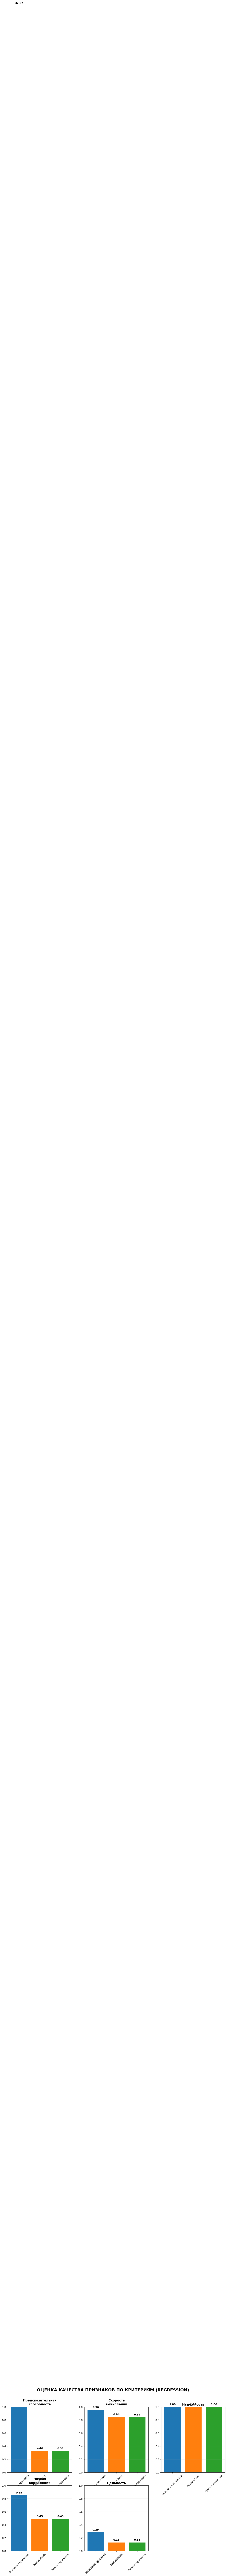

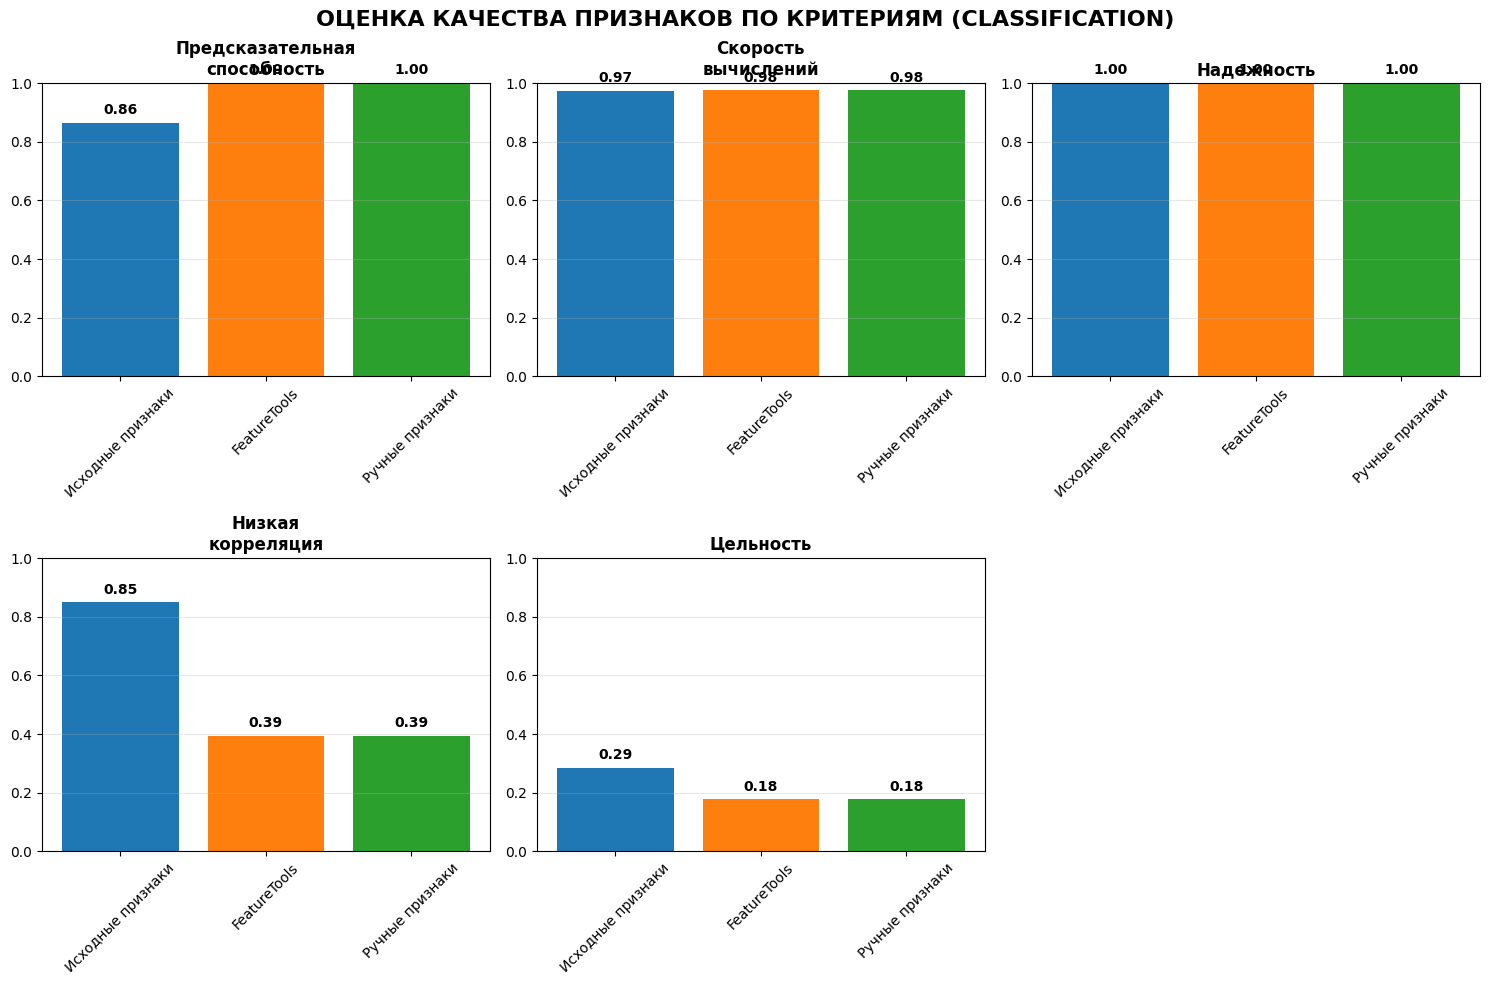

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import time
import warnings
warnings.filterwarnings('ignore')

def prepare_features(X):
    """Подготовка признаков для оценки"""
    X_prep = X.copy()
    for col in X_prep.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        X_prep[col] = le.fit_transform(X_prep[col].astype(str))
    return X_prep.fillna(0)

def evaluate_predictive_power(X, y, problem_type):
    """1. Предсказательная способность"""
    X_prep = prepare_features(X)
    
    start_time = time.time()
    if problem_type == 'regression':
        model = RandomForestRegressor(n_estimators=50, random_state=42)
        scores = cross_val_score(model, X_prep, y, cv=5, scoring='neg_mean_squared_error')
        score = -scores.mean()
    else:
        model = RandomForestClassifier(n_estimators=50, random_state=42)
        scores = cross_val_score(model, X_prep, y, cv=5, scoring='accuracy')
        score = scores.mean()
    
    computation_time = time.time() - start_time
    return score, computation_time

def evaluate_reliability(X):
    """2. Надежность"""
    missing_ratio = X.isnull().sum().sum() / (X.shape[0] * X.shape[1])
    constant_features = len([col for col in X.columns if X[col].nunique() <= 1])
    constant_ratio = constant_features / X.shape[1]
    
    reliability_score = 1 - (missing_ratio + constant_ratio) / 2
    return max(0, reliability_score)

def evaluate_correlation(X):
    """3. Корреляция"""
    X_prep = prepare_features(X)
    numeric_cols = X_prep.select_dtypes(include=[np.number]).columns
    
    if len(numeric_cols) > 1:
        corr_matrix = X_prep[numeric_cols].corr().abs()
        upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        mean_corr = upper_triangle.stack().mean()
        # Преобразуем в оценку: чем меньше корреляция, тем лучше
        correlation_score = 1 - min(mean_corr, 1.0)
    else:
        correlation_score = 1.0
    
    return correlation_score

def evaluate_integrity(X, y, problem_type):
    """4. Цельность"""
    X_prep = prepare_features(X)
    numeric_cols = X_prep.select_dtypes(include=[np.number]).columns
    
    if len(numeric_cols) > 0:
        if problem_type == 'regression':
            model = RandomForestRegressor(n_estimators=50, random_state=42)
        else:
            model = RandomForestClassifier(n_estimators=50, random_state=42)
        
        model.fit(X_prep[numeric_cols], y)
        importances = model.feature_importances_
        
        # Оценка цельности: доля информативных признаков
        mean_importance = np.mean(importances)
        informative_ratio = (importances > mean_importance).sum() / len(importances)
        integrity_score = informative_ratio
    else:
        integrity_score = 0
    
    return integrity_score

def evaluate_feature_speed(X, y, problem_type):
    """5. Скорость вычислений"""
    X_prep = prepare_features(X)
    
    start_time = time.time()
    if problem_type == 'regression':
        model = RandomForestRegressor(n_estimators=50, random_state=42)
    else:
        model = RandomForestClassifier(n_estimators=50, random_state=42)
    
    model.fit(X_prep, y)
    computation_time = time.time() - start_time
    
    # Преобразуем время в оценку: чем быстрее, тем лучше
    # Нормализуем относительно максимального ожидаемого времени (5 секунд)
    speed_score = max(0, 1 - (computation_time / 5.0))
    return speed_score, computation_time

def plot_bar_comparison(results, problem_type):
    """Столбчатые диаграммы по каждому критерию"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    criteria = {
        'predictive_score': 'Предсказательная\nспособность',
        'speed_score': 'Скорость\nвычислений', 
        'reliability_score': 'Надежность',
        'correlation_score': 'Низкая\nкорреляция',
        'integrity_score': 'Цельность'
    }
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    for idx, (metric, title) in enumerate(criteria.items()):
        if idx >= len(axes):
            break
            
        names = list(results.keys())
        scores = [results[name][metric] for name in names]
        
        bars = axes[idx].bar(names, scores, color=colors[:len(names)])
        axes[idx].set_title(title, fontweight='bold')
        axes[idx].set_ylim(0, 1)
        
        # Добавляем значения на столбцы
        for bar, score in zip(bars, scores):
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar.get_width()/2, height + 0.02,
                          f'{score:.2f}', ha='center', va='bottom', fontweight='bold')
        
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Скрываем последний пустой subplot
    if len(criteria) < len(axes):
        axes[-1].set_visible(False)
    
    plt.suptitle(f'ОЦЕНКА КАЧЕСТВА ПРИЗНАКОВ ПО КРИТЕРИЯМ ({problem_type.upper()})', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def evaluate_all_criteria(X, y, problem_type):
    """Полная оценка по всем 5 критериям"""
    # 1. Предсказательная способность и скорость
    predictive_score, predictive_time = evaluate_predictive_power(X, y, problem_type)
    
    # 2. Надежность
    reliability_score = evaluate_reliability(X)
    
    # 3. Корреляция
    correlation_score = evaluate_correlation(X)
    
    # 4. Цельность
    integrity_score = evaluate_integrity(X, y, problem_type)
    
    # 5. Скорость вычислений
    speed_score, speed_time = evaluate_feature_speed(X, y, problem_type)
    
    return {
        'predictive_score': predictive_score,
        'reliability_score': reliability_score,
        'correlation_score': correlation_score,
        'integrity_score': integrity_score,
        'speed_score': speed_score,
        'computation_time': predictive_time + speed_time,
        'feature_count': X.shape[1]
    }

# Подготовка данных
original_features = data[['reading score', 'writing score', 'gender', 'race/ethnicity', 
                         'parental level of education', 'lunch', 'test preparation course']].copy()

# Создаем наборы для оценки
feature_sets_regression = {'Исходные признаки': original_features}

if 'final_features_regression' in globals():
    feature_sets_regression['FeatureTools'] = final_features_regression
if 'X_regression' in globals():
    feature_sets_regression['Ручные признаки'] = X_regression

# Оцениваем каждый набор
results_regression = {}
for name, X in feature_sets_regression.items():
    results_regression[name] = evaluate_all_criteria(X, y_regression, 'regression')

# Визуализация результатов
plot_bar_comparison(results_regression, 'regression')

# Создаем наборы для классификации
feature_sets_classification = {'Исходные признаки': original_features}

if 'final_features_classification' in globals():
    feature_sets_classification['FeatureTools'] = final_features_classification
if 'X_classification' in globals():
    feature_sets_classification['Ручные признаки'] = X_classification

# Оцениваем каждый набор
results_classification = {}
for name, X in feature_sets_classification.items():
    results_classification[name] = evaluate_all_criteria(X, y_classification, 'classification')

# Визуализация результатов
plot_bar_comparison(results_classification, 'classification')
